In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time
from sklearn.cluster import KMeans, MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 图像URL
url = "https://imagepphcloud.thepaper.cn/pph/image/212/821/626.jpg"

# 下载图像
print("下载图像...")
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image = np.array(image)
print(f"图像尺寸: {image.shape}")

下载图像...
图像尺寸: (1209, 2010, 3)


处理 K=2...
K=2 完成，耗时: 0.36秒
处理 K=8...
K=8 完成，耗时: 0.34秒


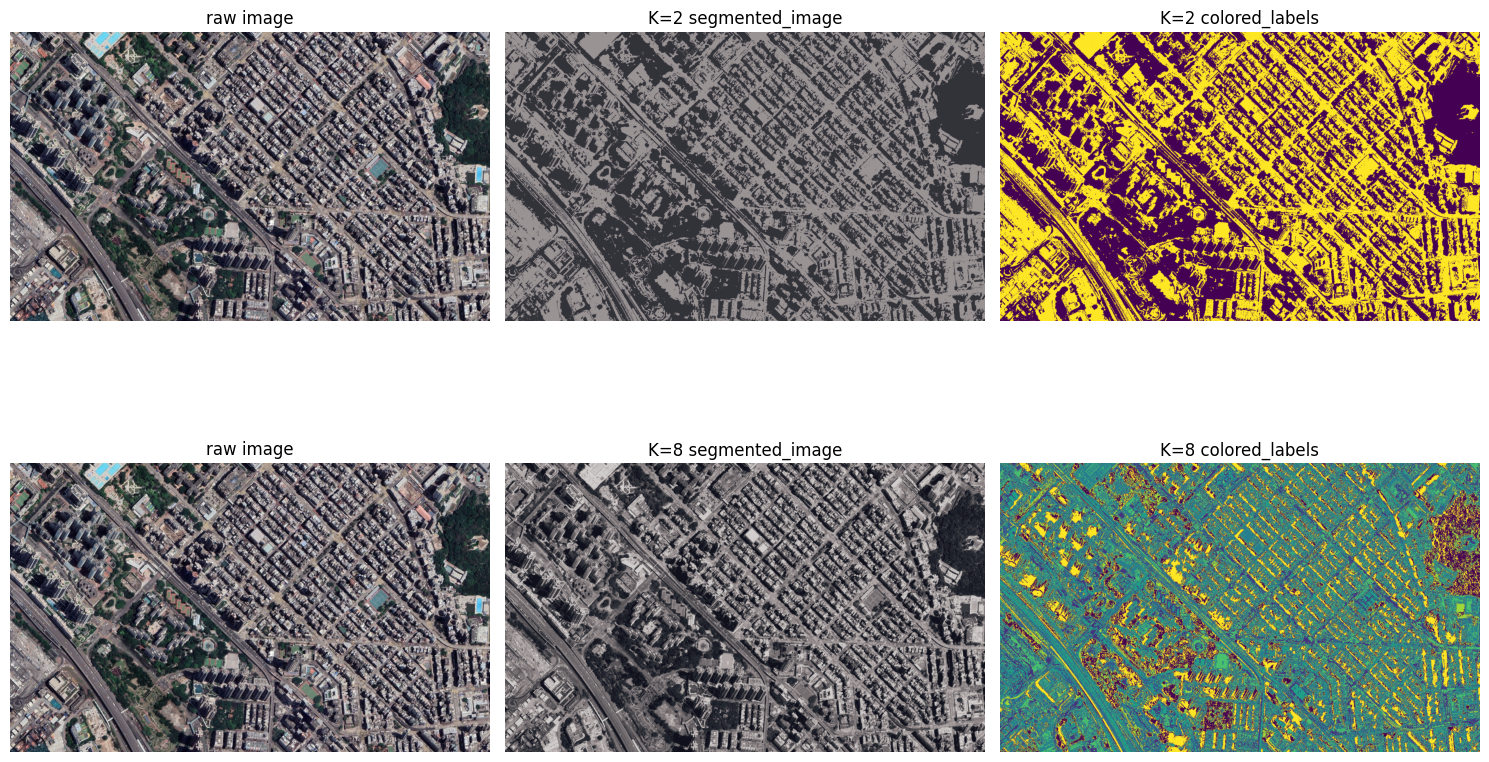

比较完成！结果已保存为 'kmeans_k_comparison.png'


In [4]:
# 比较不同K值的效果
k_values = [2, 8]

# 创建图表
fig, axes = plt.subplots(len(k_values), 3, figsize=(15, 5*len(k_values)))

# 为单个K值的情况调整轴数组形状
if len(k_values) == 1:
    axes = np.array([axes])

# 显示原始图像（所有行）
for i in range(len(k_values)):
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('raw image')
    axes[i, 0].axis('off')

# 处理每个K值
for i, k in enumerate(k_values):
    print(f"处理 K={k}...")
    start_time = time.time()
    
    # 获取图像形状
    if len(image.shape) == 3:
        height, width, channels = image.shape
    else:
        height, width = image.shape
        channels = 1
        image = image.reshape(height, width, channels)
    
    # 将图像重塑为二维数组，每行代表一个像素，每列代表一个特征(RGB值)
    pixels = image.reshape(-1, channels)
    
    # 选择合适的K-means算法
    if pixels.shape[0] > 100000:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=5, max_iter=100)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)
    
    # 训练模型并预测
    labels = kmeans.fit_predict(pixels)
    
    # 获取聚类中心
    cluster_centers = kmeans.cluster_centers_
    
    # 创建分割后的图像
    segmented_pixels = cluster_centers[labels]
    segmented_image = segmented_pixels.reshape(image.shape).astype(np.uint8)
    
    # 创建标签图像
    labels_image = labels.reshape(height, width)
    
    # 创建彩色标签图像
    colors = plt.cm.viridis(np.linspace(0, 1, k))[:, :3]  # 只保留RGB通道
    colored_labels = colors[labels_image]
    
    # 显示分割结果
    axes[i, 1].imshow(segmented_image)
    axes[i, 1].set_title(f'K={k} segmented_image')
    axes[i, 1].axis('off')
    
    # 显示标签图像
    axes[i, 2].imshow(colored_labels)
    axes[i, 2].set_title(f'K={k} colored_labels')
    axes[i, 2].axis('off')
    
    end_time = time.time()
    print(f"K={k} 完成，耗时: {end_time - start_time:.2f}秒")

plt.tight_layout()
plt.savefig('kmeans_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("比较完成！结果已保存为 'kmeans_k_comparison.png'")

In [5]:
# 快速计算轮廓系数 - 使用采样
from sklearn.metrics import silhouette_score

print("快速计算轮廓系数...")
print(f"总像素数: {pixels.shape[0]:,}")

# 为K=2和K=8重新计算并获取轮廓系数
for k in k_values:
    print(f"计算K={k}的轮廓系数...")
    
    # 重新运行kmeans获取labels
    if pixels.shape[0] > 100000:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=5, max_iter=100)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)
    
    labels = kmeans.fit_predict(pixels)
    
    # 使用采样计算轮廓系数以加速
    sample_size = min(5000, pixels.shape[0])  # 最多采样5000个点
    sample_indices = np.random.choice(pixels.shape[0], sample_size, replace=False)
    sample_pixels = pixels[sample_indices]
    sample_labels = labels[sample_indices]
    
    print(f"使用{sample_size}个采样点计算...")
    #计算轮廓系数
    score = silhouette_score(sample_pixels, sample_labels)
    print(f"K={k}: 轮廓系数 = {score:.4f}")

快速计算轮廓系数...
总像素数: 2,430,090
计算K=2的轮廓系数...
使用5000个采样点计算...
K=2: 轮廓系数 = 0.6019
计算K=8的轮廓系数...
使用5000个采样点计算...
K=8: 轮廓系数 = 0.4302
